## Initialization

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
# Load labels
labels = pd.read_csv('/datasets/faces/labels.csv')

# Quick check
print(labels.shape)
datagen = ImageDataGenerator(rescale=1.0/255)
datagen_flow = datagen.flow_from_directory(
    # the folder with the dataset
   '/datasets/faces/',
    # the target image size
    target_size=(150, 150),
    # the batch size
    batch_size=16,
    # class mode
    class_mode='sparse',
    # set a random number generator
    seed=12345,
)


(7591, 2)
Found 7591 images belonging to 1 classes.


## EDA

In [4]:
train_gen = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',  # folder with actual images
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),   # resize images
    batch_size=32,
    class_mode='raw'        
)

Found 7591 validated image filenames.


### Findings

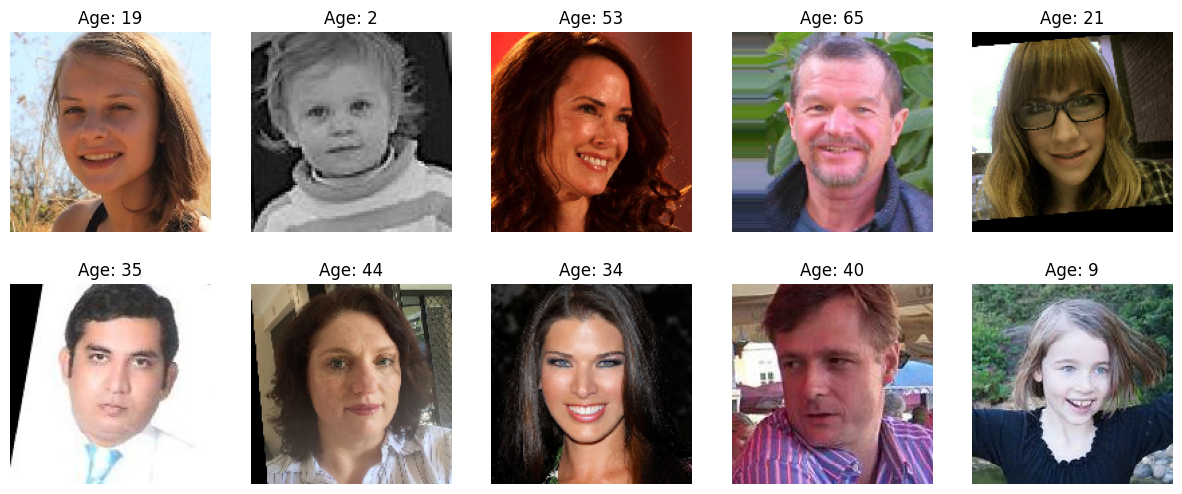

In [5]:
# Take one batch
images, ages = next(train_gen)

# Show 10 samples
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Age: {int(ages[i])}")
    plt.axis("off")
plt.show()

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,            
        validation_split=0.25,       # split into training & validation
        horizontal_flip=True,        # random flips for augmentation
        rotation_range=90,           # random rotations
        width_shift_range=0.2,     
        height_shift_range=0.2,
        vertical_flip=True
    )
    train_gen_flow = train_datagen.flow_from_directory(
        path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse',
        subset='training',
        seed=12345
    )
    return train_gen_flow

In [7]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    validation_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1.0/255
    )
    test_gen_flow = validation_datagen.flow_from_directory(
        path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse',
        subset='validation',
        seed=12345
    )

    return test_gen_flow

In [9]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    model = Sequential()
     # First conv 
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Second conv 
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # third conv
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(AvgPool2D(pool_size=(2,2)))
    
    # flatten 
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    # Output layer: 12 classes
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        verbose=2
    )
    return model


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

- **1/Training dynamics:**
The model started with a high error (MAE ≈ 7.4 years in epoch 1).

During training, the training loss and MAE steadily decreased, reaching ≈ 3.1–3.7 years MAE on the training set by the final epochs.

This shows the network is capable of fitting the data and learning age-related features.

- **2/Validation results:**
Validation MAE improved from ≈ 8.5 years initially to ≈ 6.6–7.0 years at the best point (around epochs 8–10).

After epoch 12, validation error started increasing again (up to 7.6+ years), while training error kept decreasingthis indicates overfitting.

- **3/Bias–variance tradeoff:**
The gap between training MAE (~3 years) and validation MAE (~7 years) suggests the model memorizes training examples but generalizes less effectively to unseen data.

This could be due to:
Insufficient data augmentation,
Dataset imbalances (e.g., more young or middle-aged faces than very old ones),
Model capacity being high relative to dataset size.

- **4/Data-specific challenges:**
Predicting age from faces is inherently noisy:
People of the same age can look very different (lifestyle, ethnicity, etc.),
Some labels may be inaccurate.
This explains why validation MAE plateaus around 6–7 years — a common performance level for age prediction tasks without massive datasets.

- **5/Next steps for improvement:**
Add early stopping during training to avoid overfitting.

Use transfer learning (e.g., fine-tuning ResNet50 or EfficientNet pre-trained on ImageNet).

Apply stronger augmentation (brightness, zoom, contrast, random cropping).

Try regularization (Dropout, weight decay).

Consider regression-specific losses like Huber loss, which is less sensitive to outliers than MAE.

Collect or balance more data across all age groups.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training